In [2]:
import sys
sys.argv = [sys.argv[0]]  # ignore Colab's extra arguments


In [3]:
#!/usr/bin/env python3
"""
scrape_livingcost_india_inr_hardening.py
- Usage:
    python scrape_livingcost_india_inr_hardening.py           # full run
    python scrape_livingcost_india_inr_hardening.py --test 10 # run only first 10 page candidates
- Requirements:
    pip install requests beautifulsoup4 pandas openpyxl
- Output:
    - livingcost_india_all_inr.csv
    - debug_logs.txt
    - optional ./html_snippets/<city_slug>.html (for debugging)
"""
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import time, re, csv, os, argparse, sys, traceback
import pandas as pd

BASE = "https://livingcost.org"
HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117 Safari/537.36"}
OUT_CSV = "livingcost_india_all_inr.csv"
LOGFILE = "debug_logs.txt"
SNIPPET_DIR = "html_snippets"

# fallback rate (used if exchange API fails)
FALLBACK_USD_TO_INR = 87.8638

# small helper logging
def log(msg):
    ts = time.strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{ts}] {msg}")
    with open(LOGFILE, "a", encoding="utf-8") as f:
        f.write(f"[{ts}] {msg}\n")

def get(url, timeout=15):
    for attempt in range(3):
        try:
            r = requests.get(url, headers=HEADERS, timeout=timeout)
            if r.status_code == 200:
                return r
            log(f"Non-200 for {url}: {r.status_code}")
        except Exception as e:
            log(f"Request error for {url}: {e} (attempt {attempt+1})")
        time.sleep(1 + attempt)
    return None

def fetch_usd_to_inr():
    try:
        r = requests.get("https://api.exchangerate.host/latest?base=USD&symbols=INR", timeout=8)
        r.raise_for_status()
        data = r.json()
        rate = data.get("rates", {}).get("INR")
        if rate and rate > 0:
            log(f"Fetched live USD->INR rate: {rate}")
            return float(rate)
    except Exception as e:
        log(f"Could not fetch live rate: {e}")
    log(f"Using fallback USD->INR rate: {FALLBACK_USD_TO_INR}")
    return FALLBACK_USD_TO_INR

def find_india_city_links(limit=None):
    # Attempt multiple places that might list India city links
    candidates = [
        "/cost/india",
        "/cost/country/india",   # sometimes sites use different index paths
        "/cost/asia/india"
    ]
    links = set()
    for p in candidates:
        idx_url = urljoin(BASE, p)
        r = get(idx_url)
        if not r:
            log(f"Index page not reachable: {idx_url}")
            continue
        soup = BeautifulSoup(r.text, "html.parser")
        # 1) common anchor pattern
        for a in soup.find_all("a", href=True):
            href = a["href"].strip()
            if "/cost/india/" in href and len(href.split("/")) >= 4:
                links.add(urljoin(BASE, href.split("#")[0]))
        # 2) try data attributes or JSON-LD (rare)
        # 3) also look for sitemap link on the page
        # quick stop if we have many links
        if limit and len(links) >= limit:
            break
        time.sleep(0.2)
    links = sorted(links)
    log(f"Found {len(links)} candidate links (sample 10): {links[:10]}")
    return links[:limit] if limit else links

# robust numeric extractor: picks first $-prefixed or bare number in given piece of text
def extract_first_number(text):
    if not text:
        return None
    # remove non-ascii noise
    txt = text.replace("\xa0", " ").replace(",", "")
    # try $ followed by number
    m = re.search(r"\$\s*([0-9]+(?:\.[0-9]+)?)", txt)
    if m:
        return float(m.group(1))
    # otherwise find any standalone number
    m2 = re.search(r"([0-9]+(?:\.[0-9]+)?)", txt)
    if m2:
        return float(m2.group(1))
    return None

def parse_city_page(url, save_snippet=False):
    r = get(url)
    if not r:
        log(f"Failed to fetch page {url}")
        return None
    html = r.text
    if save_snippet:
        os.makedirs(SNIPPET_DIR, exist_ok=True)
        slug = urlparse(url).path.strip("/").replace("/", "_")
        try:
            with open(os.path.join(SNIPPET_DIR, f"{slug}.html"), "w", encoding="utf-8") as f:
                f.write(html)
        except Exception as e:
            log(f"Could not save snippet for {url}: {e}")
    soup = BeautifulSoup(html, "html.parser")
    # city name
    h1 = soup.find("h1")
    city = h1.get_text(strip=True) if h1 else url.split("/")[-1]

    text = soup.get_text(separator=" ", strip=True)
    # heuristics: look for phrases that site uses
    # cost of living one person
    cost_patterns = [
        r"Cost of living(?: for)?(?: one person| - one person| \(one person\))?:?\s*\$?([0-9,]+(?:\.[0-9]+)?)",
        r"Cost of living(?:.*?)(?:\$\s*([0-9,]+(?:\.[0-9]+)?))"
    ]
    rent_patterns = [
        r"Rent & Utilities(?:.*?)(?:\$\s*([0-9,]+(?:\.[0-9]+)?))",
        r"Rent(?:.*?)(?:\$\s*([0-9,]+(?:\.[0-9]+)?))"
    ]
    salary_patterns = [
        r"Monthly salary after tax(?:.*?)(?:\$\s*([0-9,]+(?:\.[0-9]+)?))",
        r"Monthly salary(?:.*?)(?:\$\s*([0-9,]+(?:\.[0-9]+)?))"
    ]
    def find_first(patterns):
        for p in patterns:
            m = re.search(p, text, re.I|re.S)
            if m:
                try:
                    val = float(m.group(1).replace(",",""))
                    return val
                except:
                    pass
        return None

    cost = find_first(cost_patterns)
    rent = find_first(rent_patterns)
    salary = find_first(salary_patterns)

    # fallback: look near labels in DOM. Search for label text nodes then siblings
    if cost is None:
        label_nodes = soup.find_all(text=re.compile(r"cost of living", re.I))
        for node in label_nodes:
            parent = node.parent
            snippet = parent.get_text(" ", strip=True)
            cost = extract_first_number(snippet)
            if cost:
                break
    if rent is None:
        label_nodes = soup.find_all(text=re.compile(r"rent & utilities|rent", re.I))
        for node in label_nodes:
            parent = node.parent
            snippet = parent.get_text(" ", strip=True)
            rent = extract_first_number(snippet)
            if rent:
                break
    if salary is None:
        label_nodes = soup.find_all(text=re.compile(r"monthly salary", re.I))
        for node in label_nodes:
            parent = node.parent
            snippet = parent.get_text(" ", strip=True)
            salary = extract_first_number(snippet)
            if salary:
                break

    # months covered sentence
    months = None
    mmon = re.search(r"enough to cover.*?([0-9]*\.?[0-9]+)\s*months?", text, re.I)
    if mmon:
        months = float(mmon.group(1))

    # If none of primary numbers found, bail out (no data)
    if not any([cost, rent, salary, months]):
        log(f"No numeric fields found for {url} ({city}); skipping.")
        return None

    return {
        "city": city,
        "cost_one_person_usd": cost,
        "rent_one_person_usd": rent,
        "monthly_salary_after_tax_usd": salary,
        "months_covered": months,
        "source_url": url
    }

def main(limit=None, test_mode=False, save_snippets=False):
    open(LOGFILE, "w").close()
    log("START SCRAPE run")
    links = find_india_city_links(limit=limit or (10 if test_mode else None))
    if not links:
        log("No city links found — possible reasons: site structure changed or index page different. See debug_logs.txt.")
        return

    rows = []
    for i, url in enumerate(links, 1):
        log(f"[{i}/{len(links)}] Processing: {url}")
        try:
            parsed = parse_city_page(url, save_snippet=save_snippets)
            if parsed:
                # compute income after rent (if possible)
                rent = parsed.get("rent_one_person_usd") or 0.0
                salary = parsed.get("monthly_salary_after_tax_usd") or 0.0
                parsed["income_after_rent_usd"] = None if parsed.get("monthly_salary_after_tax_usd") is None else (salary - rent)
                rows.append(parsed)
                log(f"Parsed {parsed['city']}: cost={parsed.get('cost_one_person_usd')}, rent={rent}, salary={salary}, months={parsed.get('months_covered')}")
            else:
                log(f"Skipped (no relevant numeric data): {url}")
        except Exception as e:
            log(f"Exception parsing {url}: {e}")
            traceback.print_exc()
        time.sleep(0.8)  # politeness

    if not rows:
        log("No rows parsed. Exiting. Check debug_logs.txt and consider running with --test to get snippets.")
        return

    rate = fetch_usd_to_inr()
    # Build final rows and write CSV
    fieldnames = ["city","cost_one_person_usd","rent_one_person_usd","monthly_salary_after_tax_usd","income_after_rent_usd","months_covered","cost_one_person_inr","rent_one_person_inr","monthly_salary_after_tax_inr","income_after_rent_inr","usd_to_inr_rate_used","source_url"]
    with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for r in rows:
            cost = r.get("cost_one_person_usd")
            rent = r.get("rent_one_person_usd") or 0.0
            salary = r.get("monthly_salary_after_tax_usd") or 0.0
            inc = r.get("income_after_rent_usd")
            out = {
                "city": r.get("city"),
                "cost_one_person_usd": cost,
                "rent_one_person_usd": rent if rent != 0.0 else None,
                "monthly_salary_after_tax_usd": salary if salary != 0.0 else None,
                "income_after_rent_usd": inc,
                "months_covered": r.get("months_covered"),
                "cost_one_person_inr": round(cost * rate, 2) if cost else None,
                "rent_one_person_inr": round(rent * rate, 2) if rent else None,
                "monthly_salary_after_tax_inr": round(salary * rate, 2) if salary else None,
                "income_after_rent_inr": round(inc * rate, 2) if inc is not None else None,
                "usd_to_inr_rate_used": rate,
                "source_url": r.get("source_url")
            }
            writer.writerow(out)
    log(f"Wrote {OUT_CSV} with {len(rows)} rows. Done.")

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--limit", type=int, default=None, help="Limit number of candidate links to scan (for testing)")
    ap.add_argument("--test", action="store_true", help="Test mode: only check a small set of candidates")
    ap.add_argument("--save-snippets", action="store_true", help="Save HTML snippets for debugging")
    args = ap.parse_args()
    main(limit=args.limit, test_mode=args.test, save_snippets=args.save_snippets)


[2025-11-01 17:46:18] START SCRAPE run
[2025-11-01 17:46:19] Non-200 for https://livingcost.org/cost/country/india: 404
[2025-11-01 17:46:21] Non-200 for https://livingcost.org/cost/country/india: 404
[2025-11-01 17:46:23] Non-200 for https://livingcost.org/cost/country/india: 404
[2025-11-01 17:46:26] Index page not reachable: https://livingcost.org/cost/country/india
[2025-11-01 17:46:26] Non-200 for https://livingcost.org/cost/asia/india: 404
[2025-11-01 17:46:27] Non-200 for https://livingcost.org/cost/asia/india: 404
[2025-11-01 17:46:29] Non-200 for https://livingcost.org/cost/asia/india: 404
[2025-11-01 17:46:32] Index page not reachable: https://livingcost.org/cost/asia/india
[2025-11-01 17:46:32] Found 103 candidate links (sample 10): ['https://livingcost.org/cost/india/ap', 'https://livingcost.org/cost/india/ap/vijayawada', 'https://livingcost.org/cost/india/ap/visakhapatnam', 'https://livingcost.org/cost/india/as', 'https://livingcost.org/cost/india/as/guwahati', 'https://li

In [4]:
import pandas as pd

df = pd.read_csv('livingcost_india_all_inr.csv')
display(df.head())
display(df.info())

,city,cost_one_person_usd,rent_one_person_usd,monthly_salary_after_tax_usd,income_after_rent_usd,months_covered,cost_one_person_inr,rent_one_person_inr,monthly_salary_after_tax_inr,income_after_rent_inr,usd_to_inr_rate_used,source_url
0,Cost of Living in Andhra Pradesh,347.0,122.0,379.0,257.0,1.1,30488.74,10719.38,33300.38,22581.00,87.8638,https://livingcost.org/cost/india/ap
1,Cost of Living in Vijayawada,333.0,106.0,550.0,444.0,1.6,29258.65,9313.56,48325.09,39011.53,87.8638,https://livingcost.org/cost/india/ap/vijayawada
2,Cost of Living in Visakhapatnam,310.0,111.0,222.0,111.0,0.6,27237.78,9752.88,19505.76,9752.88,87.8638,https://livingcost.org/cost/india/ap/visakhapa...
3,Cost of Living in Assam,349.0,112.0,362.0,250.0,1.0,30664.47,9840.75,31806.70,21965.95,87.8638,https://livingcost.org/cost/india/as
4,Cost of Living in Guwahati,348.0,110.0,354.0,244.0,1.0,30576.60,9665.02,31103.79,21438.77,87.8638,https://livingcost.org/cost/india/as/guwahati


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   city                          103 non-null    object 
 1   cost_one_person_usd           103 non-null    float64
 2   rent_one_person_usd           103 non-null    float64
 3   monthly_salary_after_tax_usd  103 non-null    float64
 4   income_after_rent_usd         103 non-null    float64
 5   months_covered                103 non-null    float64
 6   cost_one_person_inr           103 non-null    float64
 7   rent_one_person_inr           103 non-null    float64
 8   monthly_salary_after_tax_inr  103 non-null    float64
 9   income_after_rent_inr         103 non-null    float64
 10  usd_to_inr_rate_used          103 non-null    float64
 11  source_url                    103 non-null    object 
dtypes: float64(10), object(2)
memory usage: 9.8+ KB


None

In [5]:
display(df.describe())

,cost_one_person_usd,rent_one_person_usd,monthly_salary_after_tax_usd,income_after_rent_usd,months_covered,cost_one_person_inr,rent_one_person_inr,monthly_salary_after_tax_inr,income_after_rent_inr,usd_to_inr_rate_used
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,1.030000e+02
mean,389.446602,153.888350,353.533981,199.645631,0.928155,34218.258058,13521.214175,31062.839223,17541.624951,8.786380e+01
std,73.402026,58.008763,90.771294,112.776303,0.284370,6449.380767,5096.869695,7975.510555,9908.954269,1.428035e-14
min,264.000000,74.700000,199.000000,-187.000000,0.300000,23196.040000,6563.430000,17484.900000,-16430.530000,8.786380e+01
25%,333.500000,111.000000,323.500000,149.000000,0.800000,29302.580000,9752.880000,28423.940000,13091.710000,8.786380e+01
50%,383.000000,139.000000,334.000000,179.700000,0.800000,33651.840000,12213.070000,29346.510000,15789.120000,8.786380e+01
75%,424.000000,185.000000,365.500000,251.500000,1.100000,37254.250000,16254.800000,32114.220000,22097.745000,8.786380e+01
max,705.000000,458.000000,680.000000,473.000000,1.600000,61943.980000,40241.620000,59747.380000,41559.580000,8.786380e+01


**Reasoning**:
Identify and print the cities with the highest and lowest values for cost, rent, and salary in INR.



In [6]:
print("City with highest cost_one_person_inr:")
display(df.loc[df['cost_one_person_inr'].idxmax()][['city', 'cost_one_person_inr']])

print("\nCity with lowest cost_one_person_inr:")
display(df.loc[df['cost_one_person_inr'].idxmin()][['city', 'cost_one_person_inr']])

print("\nCity with highest rent_one_person_inr:")
display(df.loc[df['rent_one_person_inr'].idxmax()][['city', 'rent_one_person_inr']])

print("\nCity with lowest rent_one_person_inr:")
display(df.loc[df['rent_one_person_inr'].idxmin()][['city', 'rent_one_person_inr']])

print("\nCity with highest monthly_salary_after_tax_inr:")
display(df.loc[df['monthly_salary_after_tax_inr'].idxmax()][['city', 'monthly_salary_after_tax_inr']])

print("\nCity with lowest monthly_salary_after_tax_inr:")
display(df.loc[df['monthly_salary_after_tax_inr'].idxmin()][['city', 'monthly_salary_after_tax_inr']])

City with highest cost_one_person_inr:


,39
city,Cost of Living in Mumbai
cost_one_person_inr,61943.98



City with lowest cost_one_person_inr:


,90
city,Cost of Living in Agra
cost_one_person_inr,23196.04



City with highest rent_one_person_inr:


,13
city,Cost of Living in Surat
rent_one_person_inr,40241.62



City with lowest rent_one_person_inr:


,96
city,Cost of Living in Varanasi
rent_one_person_inr,6563.43



City with highest monthly_salary_after_tax_inr:


,42
city,Cost of Living in Navi Mumbai
monthly_salary_after_tax_inr,59747.38



City with lowest monthly_salary_after_tax_inr:


,26
city,Cost of Living in Jamshedpur
monthly_salary_after_tax_inr,17484.9


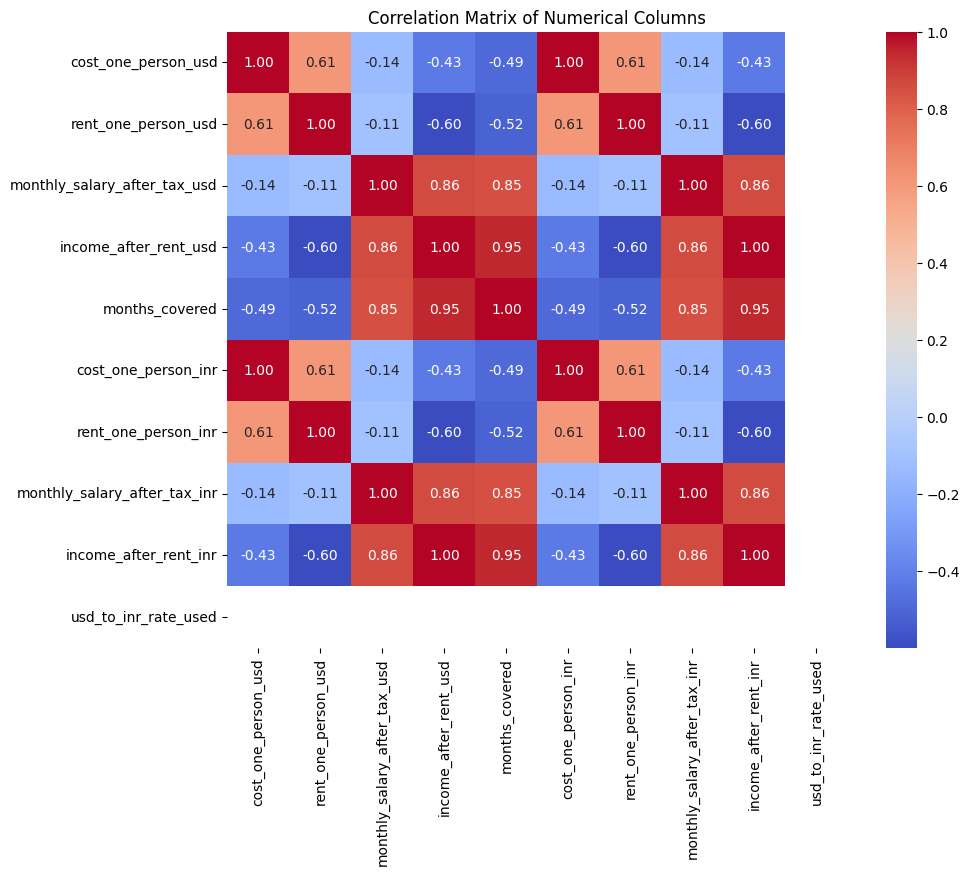

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

**Reasoning**:
Create scatter plots to visualize the relationship between 'cost_one_person_inr' and 'monthly_salary_after_tax_inr', and between 'rent_one_person_inr' and 'monthly_salary_after_tax_inr'.



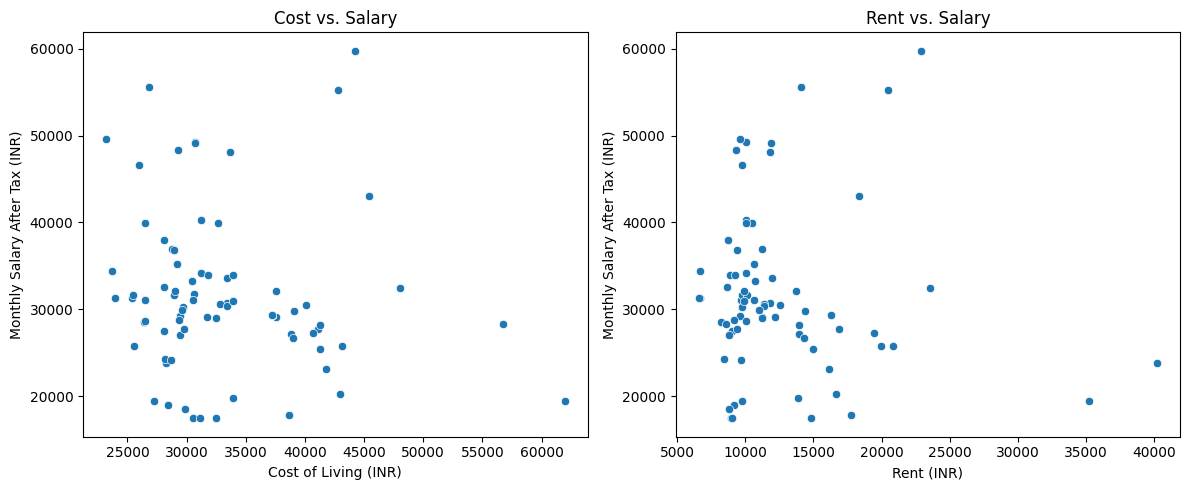

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='cost_one_person_inr', y='monthly_salary_after_tax_inr')
plt.title('Cost vs. Salary')
plt.xlabel('Cost of Living (INR)')
plt.ylabel('Monthly Salary After Tax (INR)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='rent_one_person_inr', y='monthly_salary_after_tax_inr')
plt.title('Rent vs. Salary')
plt.xlabel('Rent (INR)')
plt.ylabel('Monthly Salary After Tax (INR)')

plt.tight_layout()
plt.show()

**Reasoning**:
Analyze the 'months_covered' column and identify cities with the highest and lowest values.



In [9]:
print("City with highest months_covered:")
display(df.loc[df['months_covered'].idxmax()][['city', 'months_covered']])

print("\nCity with lowest months_covered:")
display(df.loc[df['months_covered'].idxmin()][['city', 'months_covered']])

City with highest months_covered:


,1
city,Cost of Living in Vijayawada
months_covered,1.6



City with lowest months_covered:


,39
city,Cost of Living in Mumbai
months_covered,0.3


**Reasoning**:
Filter the DataFrame to include only city-specific data and exclude rows that represent state-level or comparison data, then explore the distribution of cost, rent, and salary in INR using histograms on the filtered data.



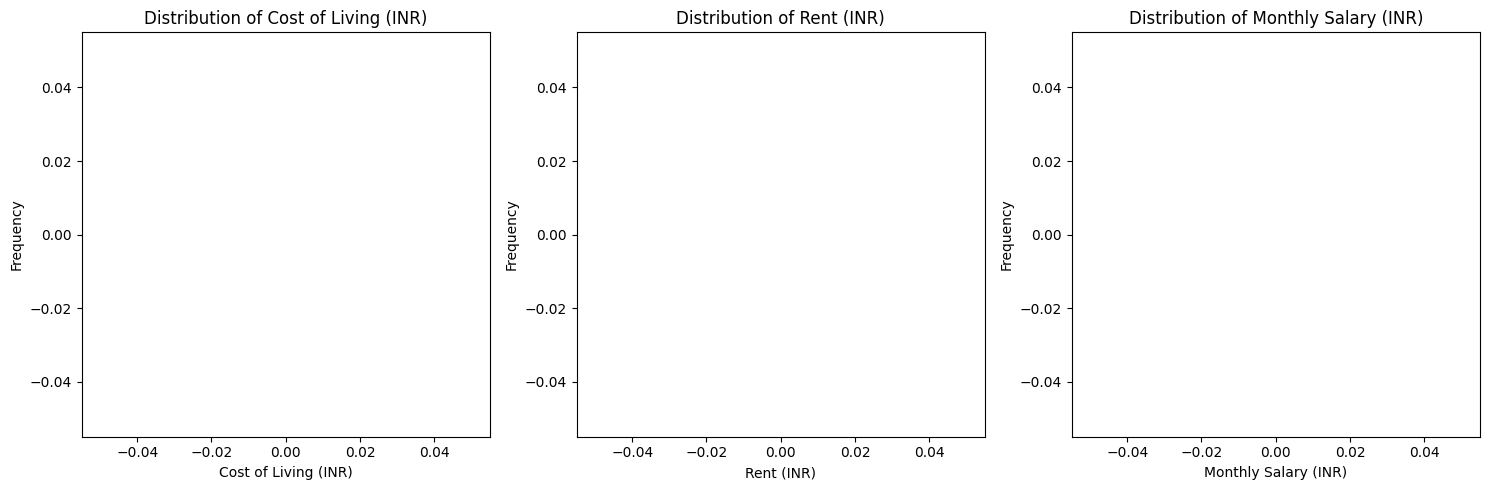

In [12]:
filtered_df = df[~df['city'].str.contains("Cost of Living in", na=False) & ~df['city'].str.contains("India", na=False)].copy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(filtered_df['cost_one_person_inr'].dropna(), kde=True)
plt.title('Distribution of Cost of Living (INR)')
plt.xlabel('Cost of Living (INR)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(filtered_df['rent_one_person_inr'].dropna(), kde=True)
plt.title('Distribution of Rent (INR)')
plt.xlabel('Rent (INR)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(filtered_df['monthly_salary_after_tax_inr'].dropna(), kde=True)
plt.title('Distribution of Monthly Salary (INR)')
plt.xlabel('Monthly Salary (INR)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
# Save Correlation Matrix Heatmap
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.savefig('correlation_heatmap.png') # Save the figure
plt.close() # Close the plot to prevent it from displaying again

# Save Scatter Plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='cost_one_person_inr', y='monthly_salary_after_tax_inr')
plt.title('Cost vs. Salary')
plt.xlabel('Cost of Living (INR)')
plt.ylabel('Monthly Salary After Tax (INR)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='rent_one_person_inr', y='monthly_salary_after_tax_inr')
plt.title('Rent vs. Salary')
plt.xlabel('Rent (INR)')
plt.ylabel('Monthly Salary After Tax (INR)')

plt.tight_layout()
plt.savefig('cost_rent_salary_scatterplots.png') # Save the figure
plt.close() # Close the plot

# Save Distribution Histograms (Filtered Data)
# Re-filter the dataframe to exclude non-city data
filtered_df = df[~df['city'].str.contains("Cost of Living in", na=False) & ~df['city'].str.contains("India vs", na=False)].copy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(filtered_df['cost_one_person_inr'].dropna(), kde=True)
plt.title('Distribution of Cost of Living (INR)')
plt.xlabel('Cost of Living (INR)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(filtered_df['rent_one_person_inr'].dropna(), kde=True)
plt.title('Distribution of Rent (INR)')
plt.xlabel('Rent (INR)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(filtered_df['monthly_salary_after_tax_inr'].dropna(), kde=True)
plt.title('Distribution of Monthly Salary (INR)')
plt.xlabel('Monthly Salary (INR)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('distribution_histograms.png') # Save the figure
plt.close() # Close the plot

print("Plots saved as PNG files: correlation_heatmap.png, cost_rent_salary_scatterplots.png, distribution_histograms.png")

Plots saved as PNG files: correlation_heatmap.png, cost_rent_salary_scatterplots.png, distribution_histograms.png
